# Introduction to the PIC-SURE API
This is a tutorial notebook aimed to get the user quickly up and running with the PIC-SURE API. 

## PIC-SURE python API
### What is PIC-SURE?
As part of the *NHLBI BioData Catalyst® (BDC)* ecosystem, the Patient Information Commons: Standard Unification of Research Elements (PIC-SURE) platform has been integrating clinical and genomic datasets from multiple TOPMed and TOPMed-related studies funded by the National Heart, Lung, and Blood Institute (NHLBI). 

Original data exposed through the PIC-SURE API encompasses a large heterogeneity of data organization underneath. PIC-SURE hides this complexity and esposes the different study datasets in a single tabular format. By simplifying the process of data extraction, it allows investigators to focus on downstream analysis and to facilitate reproducible science. 

### More about PIC-SURE
The API is available in two different programming languages, python and R, enabling investigators to query the database the same way using either language.

PIC-SURE is a larger project from which the R and python PIC-SURE APIs are only a small part. Among other things, PIC-SURE also offers a graphical user interface that allows researchers to explore variables across multiple studies, filter participants that match criteria, and create cohorts from this interactive exploration.

The python API is actively developed by the Avillach Lab at Harvard Medical School. 

PIC-SURE API GitHub repositories:
* https://github.com/hms-dbmi/pic-sure-biodatacatalyst-python-adapter-hpds
* https://github.com/hms-dbmi/pic-sure-python-adapter-hpds
* https://github.com/hms-dbmi/pic-sure-python-client

 ------- 

## Getting your user-specific security token

**Before running this notebook, please be sure to review the "Get your security token" documentation, which exists in the [`README.md` file](../README.md). It explains how to get a security token, which is mandatory to use the PIC-SURE API.**

To set up your token file, be sure to run the [`Workspace_setup.ipynb` file](./Workspace_setup.ipynb).

## Environment set-up

### Pre-requisites
* python 3.6 or later
* pip python package manager, already available in most systems with a python interpreter installed (link to pip)

### Install packages
The first step to using the PIC-SURE API is to install the packages needed. The following code installs the PIC-SURE API components from GitHub, specifically:
* PIC-SURE Client
* PIC-SURE Adapter
* *BDC-PIC-SURE* Adapter

**Note that if you are using the dedicated PIC-SURE environment within the *BDC Powered by Seven Bridges* platform, the necessary packages have already been installed.**

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
# BDC Powered by Terra users uncomment the following line to specify package install location
# sys.path.insert(0, r"/home/jupyter/.local/lib/python3.7/site-packages")

In [2]:
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-client.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-biodatacatalyst-python-adapter-hpds.git

  Cloning https://github.com/hms-dbmi/pic-sure-python-client.git to /tmp/pip-req-build-q60bs4xu
  Running command git clone --filter=blob:none --quiet https://github.com/hms-dbmi/pic-sure-python-client.git /tmp/pip-req-build-q60bs4xu
  Resolved https://github.com/hms-dbmi/pic-sure-python-client.git to commit b1c5419290fd1d7ecc1494698caae5436fb6a2e8
  Preparing metadata (setup.py) ... done
  Created wheel for PicSureClient: filename=PicSureClient-0.1.0-py2.py3-none-any.whl size=10646 sha256=0cb350ed08902b71a543db0dcbb6c8157a1290e9d0dbdba7c565cfb37441e605
  Stored in directory: /tmp/pip-ephem-wheel-cache-tj_uwa5d/wheels/90/65/c4/e74447484bdae71b64f3f0a500bc7b3d9d6ee7edc62ade6667
Successfully built PicSureClient
  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /tmp/pip-req-build-wvwte7c8
  Running command git clone --filter=blob:none --quiet https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git /tmp/pip-req-build-wvwte7c8
  Resolved https://github.com/hms-d

In [3]:
import PicSureClient
import PicSureBdcAdapter

## Connecting to a PIC-SURE resource

The following is required to get access to the PIC-SURE API:
* a network URL
* a user-specific security token

The following code specifies the network URL as the *BDC Powered by PIC-SURE* URL and references the user-specific token saved as `token.txt`.

If you have not already retrieved your user-specific token, please refer to the "Get your security token" section of the `README.md` file and the `Workspace_setup.ipynb` file.

In [4]:
PICSURE_network_URL = "https://picsure.biodatacatalyst.nhlbi.nih.gov/picsure"
token_file = "token.txt"

with open(token_file, "r") as f:
    my_token = f.read()
    
bdc = PicSureBdcAdapter.Adapter(PICSURE_network_URL, my_token)

+--------------------------------------+------------------------------------------------------+
|  Resource UUID                       |  Resource Name                                       |
+--------------------------------------+------------------------------------------------------+
| 70c837be-5ffc-11eb-ae93-0242ac130002 | open-hpds                                            |
| ca0ad4a9-130a-3a8a-ae00-e35b07f1108b | visualization                                        |
| 02e23f52-f354-4e8b-992c-d37c8b9ba140 | auth-hpds                                            |
| 36363664-6231-6134-2d38-6538652d3131 | dictionary                                           |
+--------------------------------------+------------------------------------------------------+


## Getting help with the PIC-SURE API
Each of the objects in the PIC-SURE API have a `help()` method that you can use to get more information about its functionalities.

In [5]:
bdc.help()


        [HELP] PicSureHpdsLib.Adapter(picsure_connection)
            .version()                      gives version information for library
            .list()                         lists available resources
            .useResource(resource_uuid)     returns an object for selected resource
            .unlockResource(resource_uuid, key)     For Administrators Use
        


For example, the above output lists and briefly defines the four methods that can be used with the `bdc` resource. 

## Using the PIC-SURE variables dictionary
Now that you have set up your connection to the PIC-SURE API, let's determine which study or studies you are authorized to access. The `dictionary` method can be used to search the data dictionary for a specific term or to retrieve information about all the variables you are authorized to access.

In [6]:
dictionary = bdc.useDictionary().dictionary() # Set up the dictionary
all_variables = dictionary.find() # Retrieve all variables you have access to

In [10]:
list_all_variables = all_variables.listPaths()
studies = set([i.split("\\")[1] for i in list_all_variables])
print("You are authorized to access the following studies:\n", studies)

You are authorized to access the following studies:
 {'phs001237', 'phs001194', 'phs002808', 'phs001416', 'phs002386', 'phs001189', 'phs000988', 'phs001412', 'phs002363', 'phs000703', 'phs002710', 'phs001252', 'phs000946', 'phs000166', 'phs002415', 'phs000209', 'phs001001', 'phs000954', 'phs001218', 'phs000921', 'phs002299', 'phs000964', 'phs000820', 'phs000422', 'tutorial-biolincc_camp', 'phs001215', 'phs000286', 'phs000784', 'phs000914', 'phs002362', 'phs001024', 'phs003212', 'phs000179', 'phs002383', 'phs000287', 'phs000951', 'phs001062', 'phs000997', 'phs001368', 'phs000007', 'phs000810', 'phs001032', 'phs001211', 'phs001345', 'phs000956', 'phs001207', 'phs001238', 'phs001217', 'phs000284', 'phs001013', 'tutorial-biolincc_digitalis', 'phs002715', 'phs000200', 'phs000920', 'phs002348', 'phs002385', 'phs001359', 'phs000974', 'phs001387', 'DCC Harmonized data set', 'phs002752', 'phs003063', 'phs001143', 'phs001293', 'phs000972', 'phs001074', 'phs001012', 'phs001402', 'phs001599', 'phs

For the rest of this example notebook, we will use one of the publicly available datasets available on PIC-SURE. This dataset is the "Digitalis Investigation Group (DIG) Trial: Dataset for Teaching Purposes", which is listed as `tutorial-biolincc_digitalis` in the PIC-SURE output above.

In [11]:
phs_number = "tutorial-biolincc_digitalis"

Now, let's find all of the variables associated with that study. We can search for these using the `find()` method and searching the phs accession number; in this case `tutorial-biolincc_digitalis`.
Additionally, we can view a list of the variables returned from this search using the `listPaths()` method.

In [12]:
my_variables = dictionary.find(phs_number) # Search for the phs accession number
print(my_variables.count()) # How many variables are there?
print(my_variables.listPaths()[1:10]) # 

169
['\\phs000007\\pht000009\\phv00000597\\MF129\\', '\\phs000007\\pht000009\\phv00000704\\MF249\\', '\\phs000007\\pht000009\\phv00000794\\MF344\\', '\\phs000007\\pht000009\\phv00000951\\MF509\\', '\\phs000007\\pht000010\\phv00001127\\FA116\\', '\\phs000007\\pht000010\\phv00001180\\FA180\\', '\\phs000007\\pht000011\\phv00001242\\FB65\\', '\\phs000007\\pht000011\\phv00001342\\FB194\\', '\\phs000007\\pht000011\\phv00001344\\FB196\\']


We can now review the variables that were returned and some of the information associated with these variables.

In [13]:
my_variables.count()

169

In [14]:
my_variables.listPaths()[1:10]

['\\phs000007\\pht000009\\phv00000597\\MF129\\',
 '\\phs000007\\pht000009\\phv00000704\\MF249\\',
 '\\phs000007\\pht000009\\phv00000794\\MF344\\',
 '\\phs000007\\pht000009\\phv00000951\\MF509\\',
 '\\phs000007\\pht000010\\phv00001127\\FA116\\',
 '\\phs000007\\pht000010\\phv00001180\\FA180\\',
 '\\phs000007\\pht000011\\phv00001242\\FB65\\',
 '\\phs000007\\pht000011\\phv00001342\\FB194\\',
 '\\phs000007\\pht000011\\phv00001344\\FB196\\']

The above output lists the first 10 variables in the tutorial study. 

We can view these variables in a detailed dataframe format using the `dataframe()` method.

In [15]:
my_variables_df = my_variables.dataframe() # Save the results as a dataframe
my_variables_df.head(5) # View the first 5 rows 

,values,studyId,dtId,varId,is_categorical,is_continuous,columnmeta_is_stigmatized,columnmeta_name,description,columnmeta_min,...,columnmeta_data_type,derived_var_id,columnmeta_study_id,is_stigmatized,derived_var_name,derived_study_abv_name,derived_study_description,columnmeta_var_group_id,derived_group_name,columnmeta_HPDS_PATH
0,[],tutorial-biolincc_digitalis,All Variables,CVD,False,True,false,CVD,(CVD Hospitalization): First Hospitalization f...,0.0,...,continuous,CVD,tutorial-biolincc_digitalis,false,CVD,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\CVD\
1,[],tutorial-biolincc_digitalis,All Variables,CVDDAYS,False,True,false,CVDDAYS,(Days randomization to first CVD Hosp.): Numbe...,1.0,...,continuous,CVDDAYS,tutorial-biolincc_digitalis,false,CVDDAYS,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\CVDDAYS\
2,[],tutorial-biolincc_digitalis,All Variables,HOSPDAYS,False,True,false,HOSPDAYS,(Days randomization to first Hospitalization):...,1.0,...,continuous,HOSPDAYS,tutorial-biolincc_digitalis,false,HOSPDAYS,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\HOSPDAYS\
3,[],tutorial-biolincc_digitalis,All Variables,HOSP,False,True,false,HOSP,(First Hospitalization for any reason): First ...,0.0,...,continuous,HOSP,tutorial-biolincc_digitalis,false,HOSP,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\HOSP\
4,[],tutorial-biolincc_digitalis,All Variables,NHOSP,False,True,false,NHOSP,(Number of Hospitalizations): Number of times ...,0.0,...,continuous,NHOSP,tutorial-biolincc_digitalis,false,NHOSP,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\NHOSP\


PIC-SURE integrates clinical and genomic datasets across *BDC*, including TOPMed and TOPMed-related studies, COVID-19 studies, and BioLINCC studies. Each variable is organized as a concept path that contains information about the study, variable group, and variable. Though the specifics of the concept paths are dependent on the type of study, the overall information included is the same. 

Data Organization in PIC-SURE
---------------------------------------
| Data organization | TOPMed & TOPMed-related studies | BioLINCC & COVID-19 studies (including public data) |
|-------------------|---------------------------------|-----------------------------|
| General organization | Data organized using the format implemented by the database of Genotypes and Phenotypes (dbGaP). Generally, a given study will have several tables, and those tables have several variables. | Data do not follow dbGaP format; there are no phv or pht accessions. Data are organized in groups of like variables, when available. For example, variables like Age, Gender, and Race could be part of the Demographics variable group. |
| Concept path structure | \phs\pht\phv\variable name\ | \phs\variable name |
| Variable ID | phv corresponding to the variable accession number | Equivalent to variable name | 
| Variable name | Encoded variable name that was used by the original submitters of the data | Encoded variable name that was used by the original submitters of the data |
| Variable description | Description of the variable | Description of the variable, as available |
| Dataset ID | pht corresponding to the trait table accession number | Equivalent to Dataset name | 
| Dataset name | Name of the trait table | Name of a group of like variables, as available | 
| Dataset description | Description of the trait table | Description of a group of like variables, as available |
| Study ID | phs corresponding to the study accession number | phs corresponding to the study accession number |
| Study description | Description of the study from dbGaP | Description of the study from dbGaP |



We can also view additional information for individual variables using the `varInfo()` method. 

In [16]:
first_var = my_variables.listPaths()[0]
my_variables.varInfo(first_var)

columnmeta_is_stigmatized,false
columnmeta_name,MF22
description,"HISTORY OF DRUGS TAKEN: DIGITALIS OR NITRITES, EXAM 1"
columnmeta_min,
HPDS_PATH,\phs000007\pht000009\phv00000496\MF22\
derived_group_id,pht000009.v2
columnmeta_hpds_path,\phs000007\pht000009\phv00000496\MF22\
columnmeta_var_id,phv00000496
columnmeta_var_group_description,"Clinic Exam, Original Cohort Exams 1 - 7"
derived_var_description,"HISTORY OF DRUGS TAKEN: DIGITALIS OR NITRITES, EXAM 1"
derived_variable_level_data,{}


Now you can try to search for a term on your own. Below is sample code on how to search for the term `sex`. To practice searching the data dictionary, you can change "sex" to a term you are interested in. You will see the results displayed in the convenient dataframe format using the `displayResults()` method. Note - the results displayed will show results from all studies you have access to. 

In [17]:
my_search = dictionary.find("sex") # Change sex to be your term of interest
my_search.displayResults().head()

AttributeError: 'NoneType' object has no attribute 'head'

## Using PIC-SURE to build a query and retrieve data
You can also use the PIC-SURE API to build a query and retrieve data. With this functionality, you can filter based on specific variables, add others, and export the data as a dataframe into this notebook. 

The first step to this is setting up the query object.

In [18]:
authPicSure = bdc.useAuthPicSure()
query_categorical_example = authPicSure.query()

There are several methods that can be used to build a query, which are listed below.

| Method | Arguments / Input | Output|
|--------|-------------------|-------|
| query.select.add() | variable names (string) or list of strings | all variables included in the list (no record subsetting)|
| query.require.add() | variable names (string) or list of strings | all variables; only records that do not contain null values for input variables |
| query.anyof.add() | variable names (string) or list of strings | all variables; only records that contain at least one non-null value for input variables |
| query.filter.add() | variable name and additional filtering values | input variable; only records that match filter criteria |

### Build a query with a categorical variable
Let's practice building a query by filtering on variables. First, let's select a categorical variable to use. We can identify one using the `is_categorical` column of the variable dataframe.

In [19]:
categorical_vars = my_variables_df[my_variables_df.is_categorical] # Filter to only categorical variables
categorical_vars.description.head() # View first 5 variables
#categorical_vars # Uncomment to view full dataframe

6                                         ACE INHIBITOR
8                           APPROXIMATE DURATION OF CHF
9                         ARRHYTHMIA - SUPRAVENTRICULAR
11                             ARRHYTHMIA - VENTRICULAR
15    CORONARY REVASCULARIZATION (CABG and PTCA surg...
Name: description, dtype: object

Let's do a simple filter on the `SEX` variable to select only females.

In [20]:
categorical_vars[categorical_vars.description == "SEX"] # Uncomment to view information about the variable

,values,studyId,dtId,varId,is_categorical,is_continuous,columnmeta_is_stigmatized,columnmeta_name,description,columnmeta_min,...,columnmeta_data_type,derived_var_id,columnmeta_study_id,is_stigmatized,derived_var_name,derived_study_abv_name,derived_study_description,columnmeta_var_group_id,derived_group_name,columnmeta_HPDS_PATH
62,"[Female, Male]",tutorial-biolincc_digitalis,All Variables,SEX,True,False,false,SEX,SEX,,...,categorical,SEX,tutorial-biolincc_digitalis,false,SEX,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\SEX\


In [21]:
query_categorical_example.filter().add("\\tutorial-biolincc_digitalis\\SEX\\", "Female")

Note that though we are only filtering by one value, you can filter by multiple values by passing a list into `filter()`.

Now we can export our filtered data to a pandas dataframe in this notebook using `getResultsDataFrame()`.

In [22]:
results_categorical = query_categorical_example.getResultsDataFrame(low_memory = False)
results_categorical.head()

,Patient ID,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\,\tutorial-biolincc_digitalis\SEX\
0,179516,NaN,NaN,tutorial-biolincc_digitalis,Female
1,179519,NaN,NaN,tutorial-biolincc_digitalis,Female
2,179524,NaN,NaN,tutorial-biolincc_digitalis,Female
3,179526,NaN,NaN,tutorial-biolincc_digitalis,Female
4,179545,NaN,NaN,tutorial-biolincc_digitalis,Female


In the data dictionary dataframe shown previously, each row represented a single concept path or variable. In the query dataframe, the concept paths are added as columns with each row representing a participant with data that matches your query. 

The dataframe above should contain some automatically exported concept paths, such as `Patient ID`, `Parent Study Accession with Subject ID`, `Topmed Study Accession with Subject ID`, and `consents`, and the concept path we added to our query (`\tutorial-biolincc_digitalis\SEX\`). Additionally, all participants should have the value we used to filter for our added concept path.

We can see how this query filtering worked by comparing the resulting dataframe to the full unfiltered data for this variable. Let's build a query that retrieves the data from all participants that have data for the categorical variable of interest (in this case, filtering to both males and females) using `require()`.

In [23]:
full_categorical_example = authPicSure.query() # Initialize a new query
full_categorical_example.require().add("\\tutorial-biolincc_digitalis\\SEX\\")
full_results_categorical = full_categorical_example.getResultsDataFrame(low_memory=False)
full_results_categorical.head()

,Patient ID,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\,\tutorial-biolincc_digitalis\SEX\
0,179513,NaN,NaN,tutorial-biolincc_digitalis,Male
1,179514,NaN,NaN,tutorial-biolincc_digitalis,Male
2,179515,NaN,NaN,tutorial-biolincc_digitalis,Male
3,179516,NaN,NaN,tutorial-biolincc_digitalis,Female
4,179517,NaN,NaN,tutorial-biolincc_digitalis,Male


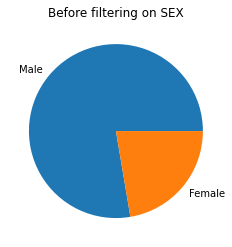

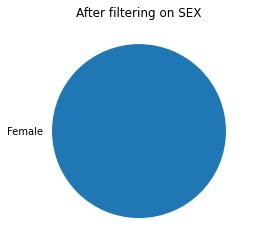

In [24]:
# Visualize the results with pie charts
full_stats = full_results_categorical["\\tutorial-biolincc_digitalis\\SEX\\"].value_counts()
plt.pie(full_stats, labels = full_stats.index)
plt.title("Before filtering on SEX")
plt.show()

stats = results_categorical["\\tutorial-biolincc_digitalis\\SEX\\"].value_counts()
plt.pie(stats, labels = stats.index)
plt.title("After filtering on SEX")
plt.show()

### Build a query with a continuous variable
Similarly, we can create a query using a continuous variable. Let's first filter to continuous variable using the `is_continuous` column.

In [25]:
continuous_vars = my_variables_df[my_variables_df.is_continuous] # Filter to only categorical variables
continuous_vars.description.head() # View first 5 variables
#continuous_vars # Uncomment to view full dataframe

0    (CVD Hospitalization): First Hospitalization f...
1    (Days randomization to first CVD Hosp.): Numbe...
2    (Days randomization to first Hospitalization):...
3    (First Hospitalization for any reason): First ...
4    (Number of Hospitalizations): Number of times ...
Name: description, dtype: object

Let's do a simple filter on age to include the age range from 30 to 50 years old.

In [26]:
#continuous_vars[continuous_vars.varId == "AGE"] # Uncomment to view information about the variable

In [27]:
query_continuous_example = authPicSure.query() # Initialize a new query
query_continuous_example.filter().add("\\tutorial-biolincc_digitalis\\AGE\\", 30, 50)

Now we can export our filtered data to a dataframe in this notebook. 

In [28]:
results_continuous = query_continuous_example.getResultsDataFrame(low_memory=False)
results_continuous.head()

,Patient ID,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\,\tutorial-biolincc_digitalis\AGE\
0,179515,NaN,NaN,tutorial-biolincc_digitalis,46.0
1,179519,NaN,NaN,tutorial-biolincc_digitalis,43.0
2,179524,NaN,NaN,tutorial-biolincc_digitalis,48.0
3,179535,NaN,NaN,tutorial-biolincc_digitalis,44.0
4,179552,NaN,NaN,tutorial-biolincc_digitalis,48.0


We can see how this query filtering worked by comparing the resulting dataframe to the full unfiltered data for this variable. Let's build a query that retrieves the data from all participants that have data for the continuous variable (in this case, participants of all ages) of interest using `require()`.

In [29]:
full_continuous_query = authPicSure.query()
full_continuous_query.require().add("\\tutorial-biolincc_digitalis\\AGE\\")
full_results_continuous = full_continuous_query.getResultsDataFrame(low_memory = False)
full_results_continuous.head()

,Patient ID,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\,\tutorial-biolincc_digitalis\AGE\
0,179513,NaN,NaN,tutorial-biolincc_digitalis,69.0
1,179514,NaN,NaN,tutorial-biolincc_digitalis,79.0
2,179515,NaN,NaN,tutorial-biolincc_digitalis,46.0
3,179516,NaN,NaN,tutorial-biolincc_digitalis,65.0
4,179517,NaN,NaN,tutorial-biolincc_digitalis,63.0


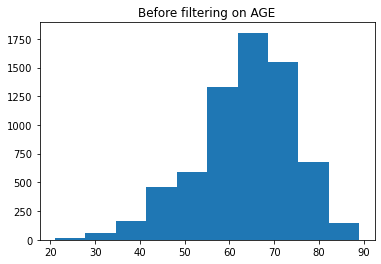

In [30]:
# Visualize results with histograms
plt.title("Before filtering on AGE")
plt.hist(full_results_continuous["\\tutorial-biolincc_digitalis\\AGE\\"])
plt.show()

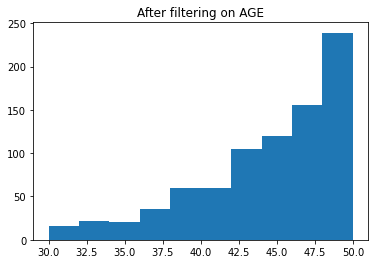

In [31]:
plt.title("After filtering on AGE")
plt.hist(results_continuous["\\tutorial-biolincc_digitalis\\AGE\\"])
plt.show()

### Build a query with multiple variables
You can also add multiple variables to a single query. Let's build a query with the first five variables for the study of interest.

In [36]:
#my_variables_df[my_variables_df.studyId == "tutorial-biolincc_digitalis"] # Uncomment to view all variables from tutorial-biolincc_digitalis

In [37]:
query_vars_concept_path = my_variables_df[my_variables_df.studyId == "tutorial-biolincc_digitalis"][0:5]
query_vars_concept_path

,values,studyId,dtId,varId,is_categorical,is_continuous,columnmeta_is_stigmatized,columnmeta_name,description,columnmeta_min,...,columnmeta_data_type,derived_var_id,columnmeta_study_id,is_stigmatized,derived_var_name,derived_study_abv_name,derived_study_description,columnmeta_var_group_id,derived_group_name,columnmeta_HPDS_PATH
0,[],tutorial-biolincc_digitalis,All Variables,CVD,False,True,false,CVD,(CVD Hospitalization): First Hospitalization f...,0.0,...,continuous,CVD,tutorial-biolincc_digitalis,false,CVD,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\CVD\
1,[],tutorial-biolincc_digitalis,All Variables,CVDDAYS,False,True,false,CVDDAYS,(Days randomization to first CVD Hosp.): Numbe...,1.0,...,continuous,CVDDAYS,tutorial-biolincc_digitalis,false,CVDDAYS,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\CVDDAYS\
2,[],tutorial-biolincc_digitalis,All Variables,HOSPDAYS,False,True,false,HOSPDAYS,(Days randomization to first Hospitalization):...,1.0,...,continuous,HOSPDAYS,tutorial-biolincc_digitalis,false,HOSPDAYS,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\HOSPDAYS\
3,[],tutorial-biolincc_digitalis,All Variables,HOSP,False,True,false,HOSP,(First Hospitalization for any reason): First ...,0.0,...,continuous,HOSP,tutorial-biolincc_digitalis,false,HOSP,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\HOSP\
4,[],tutorial-biolincc_digitalis,All Variables,NHOSP,False,True,false,NHOSP,(Number of Hospitalizations): Number of times ...,0.0,...,continuous,NHOSP,tutorial-biolincc_digitalis,false,NHOSP,biolincc_digitalis,Digitalis Investigation Group (DIG) Trial : Da...,All Variables,,\tutorial-biolincc_digitalis\NHOSP\


We can use a different method, `anyof()`, to add variables to the query. This will filter to participants that have data for at least one of the variables added.  

In [ ]:
authQuery = authPicSure.query() # Start a new query
authQuery.anyof().add(query_vars)

In [ ]:
results = authQuery.getResultsDataFrame(low_memory = False)
results.head()

### Selecting consent groups

PIC-SURE will limit results based on which study and consent groups you have been individually authorized to access. In some cases, such as instances where you can access multiple studies and/or consent groups, you may need to limit your results further to only a subset of the groups you have been authorized to access.

Let's see which studies and consent groups you are authorized to access using the `show()` method of the query.

In [ ]:
authQuery_consents = authPicSure.query()
authQuery_consents.show()

The `\\_consents\\` section of the output shown above lists all of the phs accession numbers and consent codes that you are authorized to access. 

To query on specific consent groups in this list, you must first clear the list of values within the `\\_consents\\` section and then manually replace them. Let's practice this by copying and pasting a phs accession number and consent code, deleting the `\\_consents\\` field, and adding it back with our selected consent code.

*Note that trying to manually add a consent group which you are not authorized to access will results in errors downstream.*

In [ ]:
authQuery_consents.filter().delete('\\_consents\\')
authQuery_consents.show()

In [ ]:
consent_group_filter = "<<<Paste consent group here you are authorized to access here>>>"
authQuery_consents.filter().add("\\_consents\\", consent_group_filter)
authQuery_consents.show()

Now your query is set to select only variables and participants from the phs accession and consent code you selected. From here, you can build out your query as shown above.